In [1]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
training_data_path = "cropped_training"
testing_data_path = "cropped_testing"

In [3]:
# function to get the label from the file name
def get_label_from_filename(filename):
    label = filename.split('-')[0]
    return label

In [4]:
# load the files into a dataframe
def load_files_to_dataframe(path):
    data = []
    for filename in os.listdir(path):
        label = get_label_from_filename(filename)
        image_path = os.path.join(path, filename)
        image = Image.open(image_path)
        data.append({'image': image, 'label': label,})
    return pd.DataFrame(data)

In [5]:
train_df = load_files_to_dataframe(training_data_path)
test_df = load_files_to_dataframe(testing_data_path)

In [6]:
# split into train and test sets for X and Y 
X_train = train_df['image']
X_test = test_df['image']
y_train = train_df['label']
y_test = test_df['label']

Efficientnet

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [8]:
def preprocess_images(images, target_size=(224, 224)):
    processed_images = []
    for img in images:
        img = img.resize(target_size)
        img_array = img_to_array(img)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
        processed_images.append(img_array)
    return np.array(processed_images)

In [9]:
X_train_processed = preprocess_images(X_train)
X_test_processed = preprocess_images(X_test)

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Number of classes
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

Number of classes: 26
Classes: ['4011' '4015' '4088' '4196' '7020097009819' '7020097026113'
 '7023026089401' '7035620058776' '7037203626563' '7037206100022'
 '7038010009457' '7038010013966' '7038010021145' '7038010054488'
 '7038010068980' '7039610000318' '7040513000022' '7040513001753'
 '7040913336684' '7044610874661' '7048840205868' '7071688004713'
 '7622210410337' '90433917' '90433924' '94011']


In [22]:
import joblib

# Save the label encoder for inference
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Label encoder saved to 'label_encoder.pkl'")

Label encoder saved to 'label_encoder.pkl'


In [11]:
def create_model(num_classes):
    # Load EfficientNetB0 with pre-trained weights (excluding top layers)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

In [12]:
model = create_model(num_classes)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    'efficientnet_best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [14]:
history = model.fit(
    X_train_processed,
    y_train_encoded,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.6747 - loss: 1.3549
Epoch 1: val_accuracy improved from -inf to 0.97742, saving model to efficientnet_best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 58s 367ms/step - accuracy: 0.6759 - loss: 1.3500 - val_accuracy: 0.9774 - val_loss: 0.0915
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9889 - loss: 0.0748
Epoch 2: val_accuracy improved from 0.97742 to 0.98662, saving model to efficientnet_best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 49s 328ms/step - accuracy: 0.9889 - loss: 0.0747 - val_accuracy: 0.9866 - val_loss: 0.0530
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9930 - loss: 0.0364
Epoch 3: val_accuracy improved from 0.98662 to 0.98997, saving model to efficientnet_best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 52s 345ms/step - accuracy: 0.9930 - loss: 0.0363 - val_accuracy: 0.9900 - val_loss: 0.0379
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9979 - loss: 0.0186
Epoch 4: val_accuracy improved from 0.98997 to 0.99164, saving model to efficientnet_best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 335ms/step - accuracy: 0.9979 - loss: 0.0186 - val_accuracy: 0.9916 - val_loss: 0.0272
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9986 - loss: 0.0137
Epoch 5: val_accuracy did not improve from 0.99164
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 338ms/step - accuracy: 0.9986 - loss: 0.0137 - val_accuracy: 0.9908 - val_loss: 0.0314
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9985 - loss: 0.0101
Epoch 6: val_accuracy did not improve from 0.99164
150/150 ━━━━━━━━━━━━━━━━━━━━ 48s 318ms/step - accuracy: 0.9985 - loss: 0.0101 - val_accuracy: 0.9900 - val_loss: 0.0263
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9967 - loss: 0.0104
Epoch 7: val_accuracy improved from 0.99164 to 0.99331, saving model to efficientnet_best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 333ms/step - accuracy: 0.9967 - loss: 0.0104 - val_accuracy: 0.9933 - val_loss: 0.0196
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 1.0000 - loss: 0.0048
Epoch 8: val_accuracy improved from 0.99331 to 0.99415, saving model to efficientnet_best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 48s 322ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.9941 - val_loss: 0.0163
Epoch 9/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9998 - loss: 0.0035
Epoch 9: val_accuracy improved from 0.99415 to 0.99498, saving model to efficientnet_best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 331ms/step - accuracy: 0.9998 - loss: 0.0035 - val_accuracy: 0.9950 - val_loss: 0.0152
Epoch 10/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9977 - loss: 0.0088
Epoch 10: val_accuracy did not improve from 0.99498
150/150 ━━━━━━━━━━━━━━━━━━━━ 49s 326ms/step - accuracy: 0.9977 - loss: 0.0088 - val_accuracy: 0.9916 - val_loss: 0.0296
Restoring model weights from the end of the best epoch: 9.


In [15]:
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test_encoded)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - accuracy: 0.9856 - loss: 0.0583
Test accuracy: 0.9854
Test loss: 0.0556


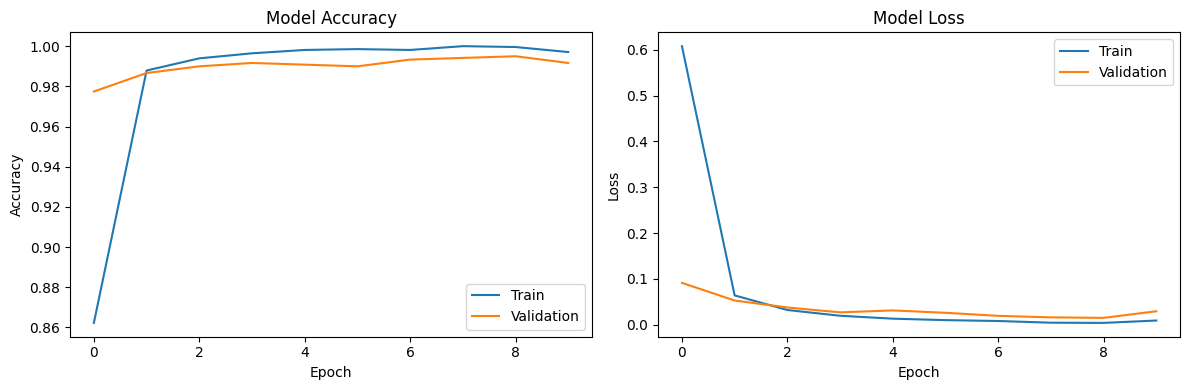

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [17]:
y_pred = model.predict(X_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

         4011       1.00      1.00      1.00        58
         4015       1.00      1.00      1.00        58
         4088       1.00      1.00      1.00        58
         4196       1.00      1.00      1.00        58
7020097009819       1.00      0.97      0.98        58
7020097026113       1.00      1.00      1.00        58
7023026089401       1.00      1.00      1.00        58
7035620058776       1.00      1.00      1.00        58
7037203626563       1.00      1.00      1.00        58
7037206100022       1.00      1.00      1.00        58
7038010009457       1.00      1.00      1.00        58
7038010013966       0.88      1.00      0.94        58
7038010021145       0.89      0.86      0.88        58
7038010054488       1.00      1.00      1.00        58
7038010068980       1.00      1.00      1.00        58
7039610000318       1.00      1.00      1.00        58
7040513000022       1.00      0.90      0.95        58
704051300

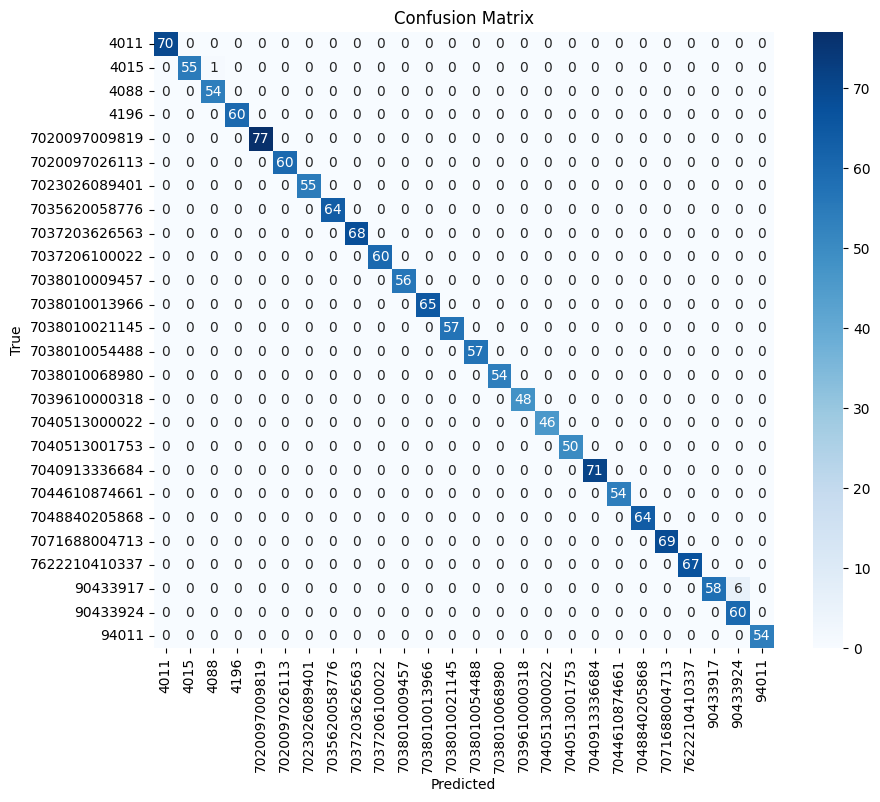

In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_encoded, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# model.fit(
#     X_train_processed,
#     y_train_encoded,
#     batch_size=32,
#     epochs=4
# )

Epoch 1/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 54s 290ms/step - accuracy: 0.9983 - loss: 0.0080
Epoch 2/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 55s 292ms/step - accuracy: 0.9994 - loss: 0.0044
Epoch 3/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 51s 272ms/step - accuracy: 0.9996 - loss: 0.0042
Epoch 4/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 51s 275ms/step - accuracy: 0.9979 - loss: 0.0066


In [ ]:
# model.save('efficientnet_final_production_model.h5')

In [ ]:
# test_loss, test_accuracy = model.evaluate(X_test_processed, y_test_encoded)
# print(f"Test accuracy: {test_accuracy:.4f}")
# print(f"Test loss: {test_loss:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 259ms/step - accuracy: 0.9754 - loss: 0.0862
Test accuracy: 0.9768
Test loss: 0.0790
